# JV Analysis
## Definitions

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import seaborn as sns

# Set the path to the folder containing text files
parent_folder_path = "C:\\Users\\w16025698\\OneDrive - Northumbria University - Production Azure AD\\PhD\\Characterisation\\JV\\"
subfolder_names = ['230221D_JV', '230221J_JV']

# Loop through sub folders dictionary creation
dfs = {}  # initialize empty dictionary to store dataframes

# Loop through sub folders
for subfolder_name in subfolder_names:
    
    folder_path = os.path.join(parent_folder_path, subfolder_name)
    
    # create an empty DataFrame to store the data
    df_concatenated = pd.DataFrame()
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".txt"):
            # Read the data from the text file, skipping the first 12 lines
            data = np.loadtxt(os.path.join(folder_path, file_name), skiprows=12)

            # Extract the voltage and current data from the columns
            V = data[:,0]
            A = data[:,1] 
            mV = V * 1000
            mA = A * 1000

            # Cell area cm2 and incident power density mW/cm2
            cell_area = 0.16
            incident_power_density = 1000
            
            # Current density mA/cm2
            current_density = mA / cell_area
            
            # Interpolate more data points
            jv_interp = interp1d(mV, current_density, kind='linear', bounds_error=False, fill_value="extrapolate")
            mV_i = np.linspace(-100, 600, 600)
            current_density_i = jv_interp(mV_i)

            # Calculate the power density from the voltage and current density data: units mW/cm2
            power_density = current_density_i * mV_i / incident_power_density

            # Indices of max power point
            max_power_index = np.argmax(power_density)

            # Calculate the open circuit voltage, short circuit current, fill factor, and efficiency
            short_circuit_index = np.where(np.diff(np.sign(mV_i)))
            short_circuit_current = current_density_i[short_circuit_index]
            open_circuit_index = np.where(np.diff(np.sign(current_density_i)))
            open_circuit_voltage = mV_i[open_circuit_index]
            fill_factor = 100 * (mV_i[max_power_index] * current_density_i[max_power_index]) / (open_circuit_voltage[0] * short_circuit_current[0])
            efficiency = 0.01 * short_circuit_current[0] * open_circuit_voltage[0] * fill_factor / incident_power_density

            # gradient calculation
            grad = np.gradient(current_density_i, mV_i)
            Voc_slope = grad[open_circuit_index]
            Rs = 1 / np.abs(Voc_slope)
            Jsc_slope = grad[0]
            Rsh = 1 / np.abs(Jsc_slope)

            # Create a DataFrame for the current file's data
            df = pd.DataFrame({'file_name': [file_name], 'efficiency': [efficiency], 
                               'open_circuit_voltage': [open_circuit_voltage[0]], 
                               'short_circuit_current': [short_circuit_current[0]], 'fill_factor': [fill_factor], 
                               'Rs': [Rs[0]], 'Rsh': [Rsh], 'mV_i': [mV_i], 'current_density_i': [current_density_i], 
                               'mV': [mV], 'current_density': [current_density]})

            # Concatenate the current DataFrame with the previous one
            df_concatenated = pd.concat([df_concatenated, df], ignore_index=True)

    # Store the DataFrame in the dictionary with unique keys
    dfs[subfolder_name] = df_concatenated

## Display Dataframe

In [2]:
display(dfs['230221D_JV'])

,file_name,efficiency,open_circuit_voltage,short_circuit_current,fill_factor,Rs,Rsh,mV_i,current_density_i,mV,current_density
0,A1.txt,1.818724,328.881469,17.968540,30.776176,12.511984,44.747349,"[-100.0, -98.8313856427379, -97.6627712854758,...","[20.653231536180474, 20.627115701550768, 20.60...","[-499.9029, -489.7049, -479.76858, -469.70754,...","[24.372212499999996, 24.382624999999997, 24.32..."
1,A7.txt,3.207258,352.253756,22.800780,39.932694,7.243108,623.521930,"[-100.0, -98.8313856427379, -97.6627712854758,...","[23.419035504775973, 23.417161289448895, 23.41...","[-499.9085, -489.72310000000004, -479.79024, -...","[24.179475, 24.19791875, 24.17557375, 24.16956..."
2,B1.txt,2.917546,359.265442,23.143356,35.089397,8.526228,106.898116,"[-100.0, -98.8313856427379, -97.6627712854758,...","[24.626127650012272, 24.61519561116967, 24.603...","[-499.9133, -489.7392, -479.79768, -469.73524,...","[26.030025000000002, 26.087750000000003, 26.03..."
3,B8.txt,3.399695,349.916528,24.026282,40.437926,6.587921,200.550456,"[-100.0, -98.8313856427379, -97.6627712854758,...","[24.643967818393584, 24.638140784227122, 24.63...","[-499.888, -489.7061, -479.7715, -469.71436, -...","[25.4966, 25.480887499999998, 25.5107987499999..."
4,C6.txt,2.539726,262.270451,23.339239,41.490708,3.447825,272.255732,"[-100.0, -98.8313856427379, -97.6627712854758,...","[24.62034209688559, 24.61604975619632, 24.6121...","[-499.9031, -489.7127, -479.779, -469.7158, -4...","[25.368637500000002, 25.355100000000004, 25.32..."


## Box Plot Plotting



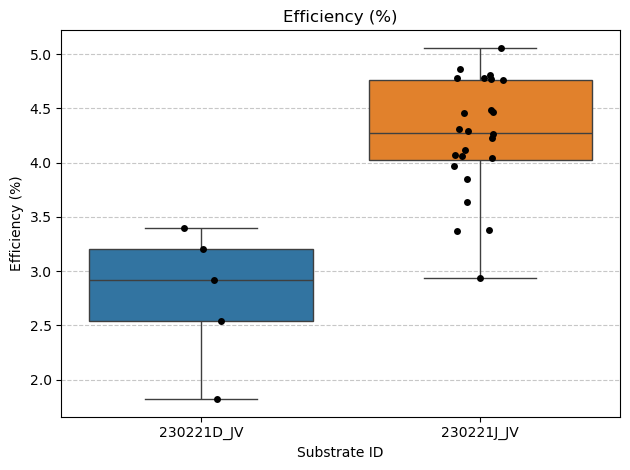

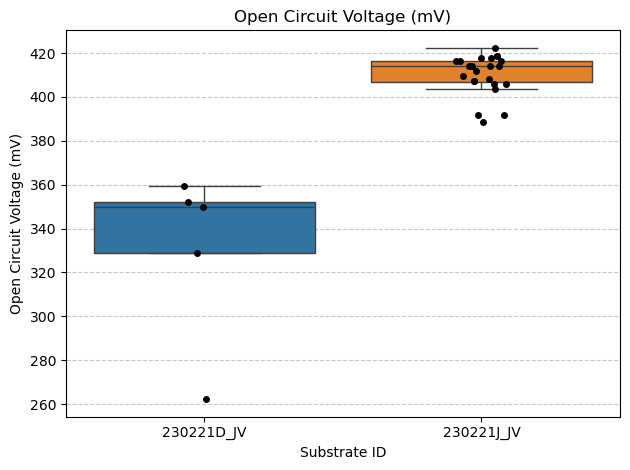

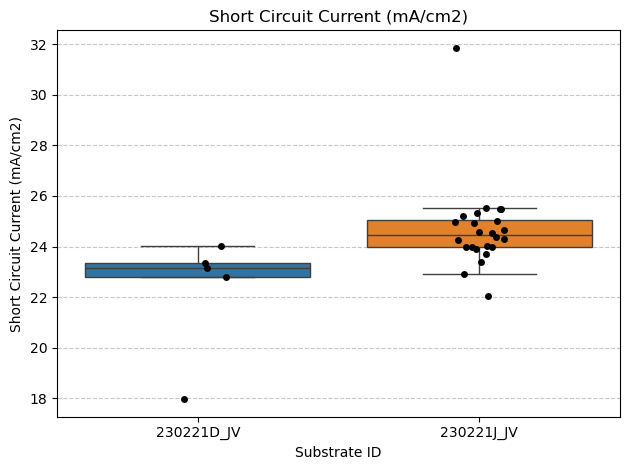

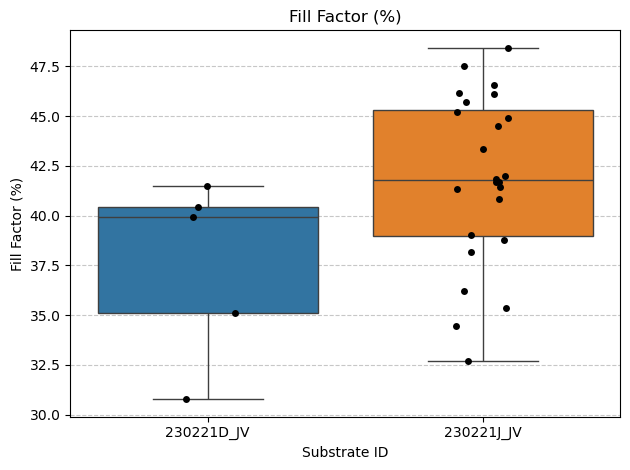

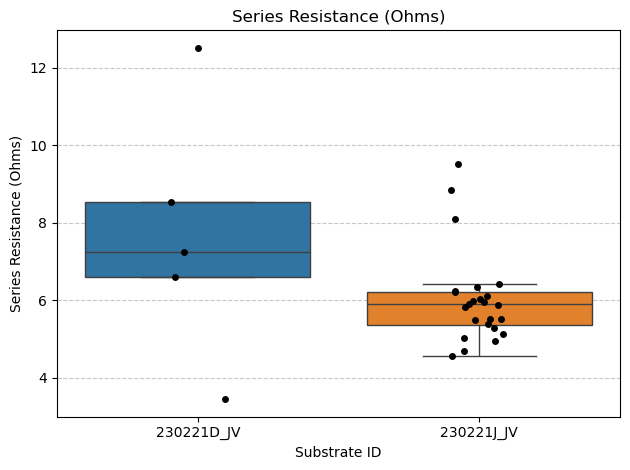

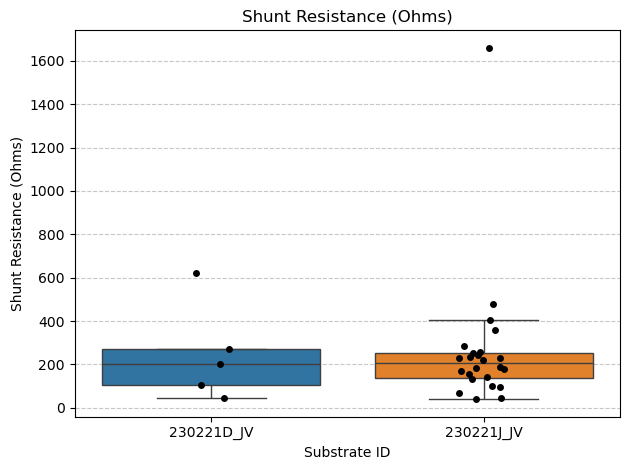

In [3]:
parameter_names = ['efficiency', 'open_circuit_voltage', 'short_circuit_current', 'fill_factor', 'Rs', 'Rsh']
titles = ['Efficiency (%)', 'Open Circuit Voltage (mV)', 'Short Circuit Current (mA/cm2)', 'Fill Factor (%)', 'Series Resistance (Ohms)', 'Shunt Resistance (Ohms)']


# loop through the parameters and create a boxplot for each one
for i, param in enumerate(parameter_names):
    plt.figure(i+1)  # create a new figure
    data = []  # initialize an empty list to store the data for this parameter
    
    # loop through the dataframes and extract the relevant parameter data
    for key, df in dfs.items():
        data.append(df[param].values)

    # create the boxplot and stripplot
    sns.boxplot(data=data, showfliers=False)
    sns.stripplot(data=data, color='black')
    
    # set the y-axis label
    plt.ylabel(titles[i])
    plt.xlabel('Substrate ID')
    
    # set the title and x-axis label
    plt.title(parameter_names[i])

    # set the title
    plt.title(titles[i])
    # set the x-tick labels
    plt.xticks(ticks=range(len(subfolder_names)), labels=subfolder_names)
    
    # add horizontal grid lines
    plt.grid(axis='y', linestyle='--', alpha=0.7)
   
    # Adjust spacing between subplots and display the plot
    plt.tight_layout()
    
    # show the plot
    plt.show()

## Box plot subplot

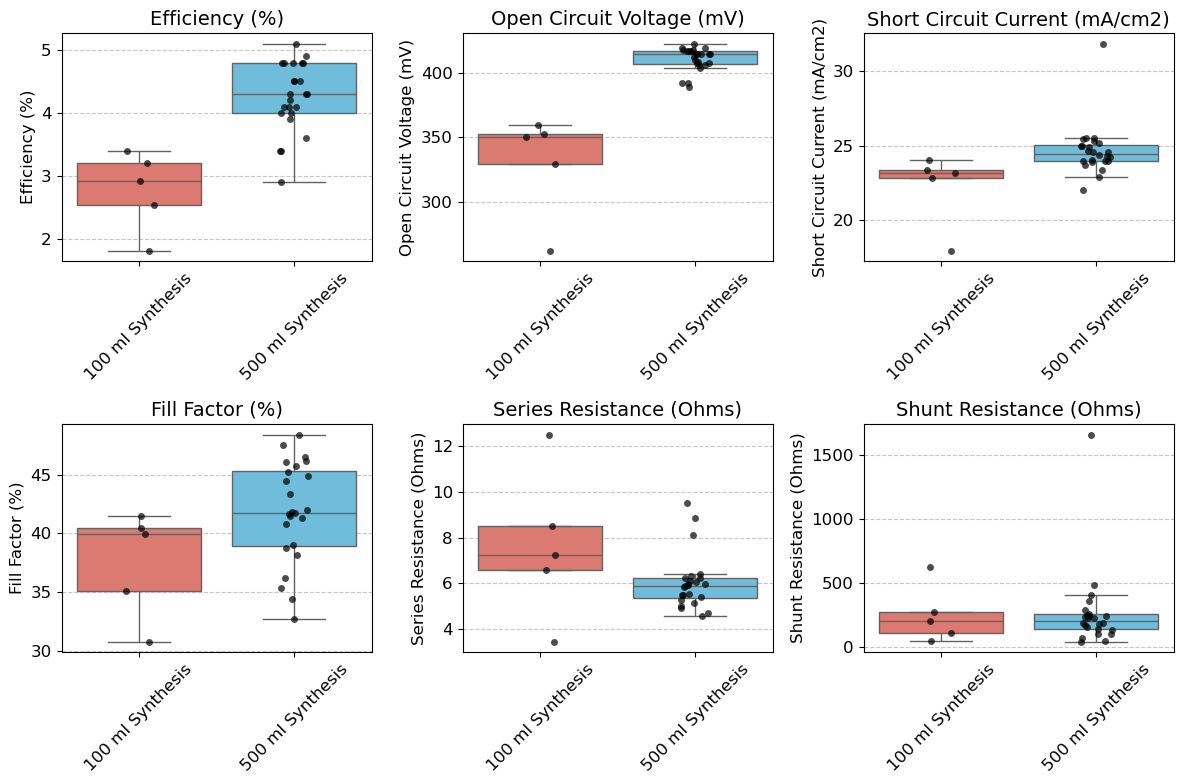

In [17]:
parameter_names = ['efficiency', 'open_circuit_voltage', 'short_circuit_current', 'fill_factor', 'Rs', 'Rsh']
titles = ['Efficiency (%)', 'Open Circuit Voltage (mV)', 'Short Circuit Current (mA/cm2)', 'Fill Factor (%)', 'Series Resistance (Ohms)', 'Shunt Resistance (Ohms)']
subfolder_names = ['100 ml Synthesis', '500 ml Synthesis']

boxplot_title = 'Large Batch Comparison 27.04.23'

# Set font sizes
plt.rcParams.update({
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'font.size': 12
})

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Flatten the 2D axes array into a 1D array for easy iteration
axes = axes.flatten()

# custom_palette = 'Blues'
custom_palette = ['#ED6B5E', '#5DC4ED']

# Loop through the parameters and create a boxplot for each one
for i, param in enumerate(parameter_names):
    data = []  # initialize an empty list to store the data for this parameter
    
    # loop through the dataframes and extract the relevant parameter data
    for key, df in dfs.items():
        data.append(df[param].values)

    # create the boxplot and stripplot on the current subplot
    sns.boxplot(ax=axes[i], data=data, showfliers=False, palette=custom_palette)
    sns.stripplot(ax=axes[i], data=data, color='black', alpha=0.7)
    
    # set the y-axis label and title for the current subplot
    axes[i].set_ylabel(titles[i])
    #axes[i].set_xlabel('Substrate ID')
    axes[i].set_title(titles[i])

    # set the x-tick labels for the current subplot
    axes[i].set_xticks(range(len(subfolder_names)))
    axes[i].set_xticklabels(subfolder_names, rotation=45)
    
    # add horizontal grid lines
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
   
    # Adjust spacing between subplots and display the plot
    plt.tight_layout()

# Figure save settings
save_dir = os.path.join(parent_folder_path, 'Box Plots and Heat Maps')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
plt.savefig(os.path.join(save_dir, boxplot_title + '.png'), dpi=600)

## Heatmap

<Axes: xlabel='x', ylabel='y'>

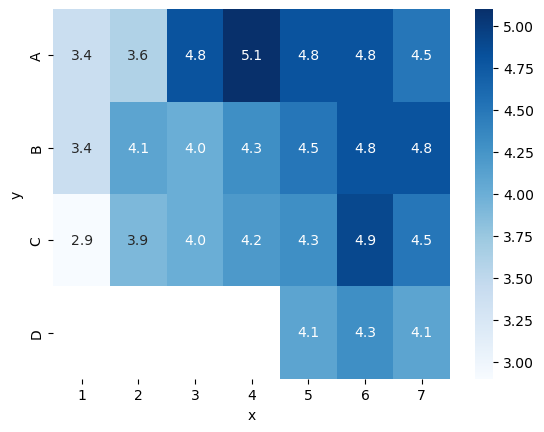

In [5]:
# Define the x and y values of the heatmap
df['file_name'] = df['file_name'].astype(str)
df['x'] = df['file_name'].str.extract(r'(\d+)').astype(int)  # Extract numbers as integers
df['y'] = df['file_name'].str.extract(r'([A-Za-z]+)')  # Extract first letters

# Define the rows and columns to display in the heatmap
all_rows = df['y'].unique()
all_columns = df['x'].unique()

df['efficiency'] = df['efficiency'].round(1)
pivot = df.pivot_table(index='y', columns='x', values='efficiency')

sns.heatmap(pivot, annot=True, fmt='.1f', cmap='Blues')
# plt.xticks(ticks=np.arange(len(all_columns)), labels=all_columns)
# plt.yticks(ticks=np.arange(len(all_rows)), labels=all_rows)

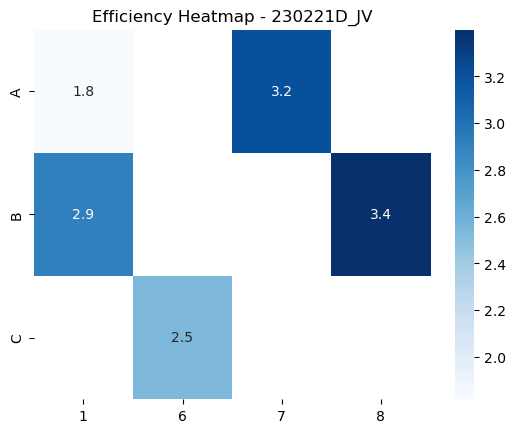

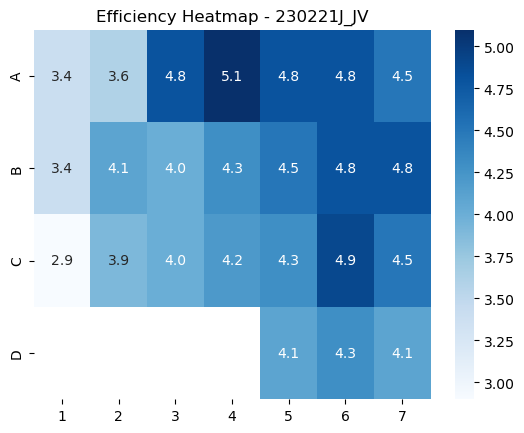

In [7]:
# Define the x and y values of the heatmap
df['file_name'] = df['file_name'].astype(str)
df['x'] = df['file_name'].str.extract(r'(\d+)').astype(int)  # Extract numbers as integers
df['y'] = df['file_name'].str.extract(r'([A-Za-z]+)')  # Extract first letters

# Define the rows and columns to display in the heatmap
all_rows = df['y'].unique()
all_columns = df['x'].unique()

# rows_to_display = ['A', 'B', 'C']
# columns_to_display = ['2', '3', '4', '5']

# Loop over the DataFrames in the dfs dictionary
for df_name, df in dfs.items():
    # plt.figure(figsize=(10, 6))  # Adjust the width and height as needed
    if df.empty:
        continue  # Skip to the next DataFrame if empty
    
    # Create a pivot table with the 'efficiency' values
    pivot = df.pivot_table(index='y', columns='x', values='efficiency')

    # Create the heatmap using seaborn
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='Blues')

    # Set the plot title and axis labels
    heatmap_title = f'Efficiency Heatmap - {df_name}'
    plt.xlabel('')
    plt.ylabel('')
    plt.title(heatmap_title)
    plt.rcParams['font.size'] = 10 
    plt.show()

## Multiple JV plot

In [ ]:
# Define a list of filenames and their corresponding subfolders to plot
file_info = [('230221J_JV', 'A1.txt'), 
             ('230221J_JV', 'A4.txt'),
             ('230221D_JV', 'A7.txt'),
            ('230221J_JV', 'A6.txt')]

# Set up the plot
fig, ax1 = plt.subplots()

# Set the labels for the x-axis and y-axis of the graph
ax1.set_xlabel("Voltage (mV)")
ax1.set_ylabel("Current Density ($mA/cm^2$)")

# Iterate through each file and plot its JV curve
for subfolder, file_name in file_info:
    # Load the dataframe for the current subfolder
    df = dfs[subfolder]
    
    # Extract the data for current density and mV for the current file
    df_file = df[df['file_name'] == file_name]
    current_density = df_file['current_density'].values
    mV = df_file['mV'].values
    
    # Plot the JV curve as a scatter plot and a line plot
    ax1.scatter(mV[0], current_density[0], alpha=0.8, marker='x')
    ax1.plot(mV[0], current_density[0], label=file_name)

# Add a legend to the plot
ax1.legend()

# Set the limits of the y-axis and x-axis
ax1.set_ylim(-5, 30)
ax1.set_xlim(-50, 600)

# Add gridlines to the plot
ax1.grid()

# Add horizontal and vertical lines at the 0 position on the y-axis and x-axis, respectively
plt.axhline(0, color='k')
plt.axvline(0, color='k')

# Show the plot
plt.show()
